### Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

from time import time
import os
import wandb
from wandb.keras import WandbCallback
import numpy as np

Using TensorFlow backend.


### Logging code

In [4]:
TENSORBOARD_LOGS_DIR = f"dandc-{int(time())}"
tensorboard = TensorBoard(log_dir=f"logs/{TENSORBOARD_LOGS_DIR}", write_images=True, histogram_freq=1, write_grads=True)
# run = wandb.init()
# config = run.config

### Network Configuration

In [5]:
config = {
    'img_width': 150,
    'img_height': 150,
    'first_layer_conv_width': 3,
    'first_layer_conv_height': 3,
    'dense_layer_size': 512,
    'epochs': 10,    
    'optimizer': "adam",
    'hidden_nodes': 100
}

### Images Dataset

In [6]:
base_dir = 'E:\kaggle\dogs-and-cats\sm_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


### Data Generation

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Inspect Generators

In [8]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


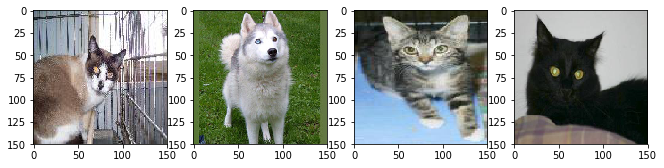

In [9]:
%matplotlib inline
rcParams['figure.figsize'] = 11, 8

fig, ax = plt.subplots(1,4)
for data_batch, labels_batch in train_generator:
    ax[0].imshow(data_batch[0])
    ax[1].imshow(data_batch[1])
    ax[2].imshow(data_batch[2])
    ax[3].imshow(data_batch[3])
    break

### Create Model

In [10]:
model = Sequential()
model.add(Conv2D(32,
                (config['first_layer_conv_width'], config['first_layer_conv_height']),
                input_shape=(config['img_width'], config['img_height'], 3),
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(config['dense_layer_size'], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

### Training

In [12]:
class TensorBoardWrapper(TensorBoard):
    '''Sets the self.validation_data property for use with TensorBoard callback.'''

    def __init__(self, batch_gen, nb_steps, b_size, **kwargs):
        super(TensorBoardWrapper, self).__init__(**kwargs)
        self.batch_gen = batch_gen # The generator.
        self.nb_steps = nb_steps   # Number of times to call next() on the generator.
        #self.batch_size = b_size

    def on_epoch_end(self, epoch, logs):
        # Fill in the `validation_data` property. Obviously this is specific to how your generator works.
        # Below is an example that yields images and classification tags.
        # After it's filled in, the regular on_epoch_end method has access to the validation_data.
        imgs, tags = None, None
        for s in range(self.nb_steps):
            ib, tb = next(self.batch_gen)
            if imgs is None and tags is None:
                imgs = np.zeros(((self.nb_steps * self.batch_size,) + ib.shape[1:]), dtype=np.float32)
                tags = np.zeros(((self.nb_steps * self.batch_size,) + tb.shape[1:]), dtype=np.uint8)
            imgs[s * ib.shape[0]:(s + 1) * ib.shape[0]] = ib
            tags[s * tb.shape[0]:(s + 1) * tb.shape[0]] = tb
        
        self.validation_data = [imgs, tags, np.ones(imgs.shape[0])]
              
        return super(TensorBoardWrapper, self).on_epoch_end(epoch, logs)

In [13]:
tbw = TensorBoardWrapper(validation_generator, nb_steps=50 // 20, b_size=20, log_dir='./log',
                       histogram_freq=1,
                       write_graph=False, write_grads=True)

In [15]:
histoty = model.fit_generator(train_generator, epochs=config['epochs'], steps_per_epoch=100, validation_data=validation_generator, validation_steps=50, callbacks=[])

Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[20,32,148,148] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_1/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/conv2d_1/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/conv2d_1/convolution_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/mul/_143}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1036_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


### Save model

In [2]:
model.save('candd01.h5')

NameError: name 'model' is not defined